In [63]:
#from google.colab import drive
#drive.mount('/content/drive')

In [64]:
!pip install sentence_transformers
!pip install umap-learn
!pip install hdbscan

You should consider upgrading via the '/Users/isabelasarmiento/pythonProject/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/isabelasarmiento/pythonProject/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/isabelasarmiento/pythonProject/venv/bin/python -m pip install --upgrade pip' command.


# Punto 1

In [65]:
import json
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
import ssl
from sklearn.feature_extraction.text import CountVectorizer

In [66]:
#prefix = './drive/MyDrive/'
prefix = ''
italian_path = prefix + 'datasets/italian/italianSmall.json'
spanish_path = prefix + 'datasets/spanish/spanishSmall.json'
english_path = prefix + 'datasets/english/englishSmall.json'


In [67]:
# english_path
file = open(english_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
english_raw = pd.json_normalize(data)

print(english_raw.shape)
english_raw.head(10)

(10000, 4)


,id,publication_date,source,text
0,1295929115770593287,1.597809e+09,twitter,Info Source:
1,1296738518216011777,1.598002e+09,twitter,#PostponeJEE_NEETSept #ProtestAgainstExamsInCO...
2,1252450676015198210,1.587442e+09,twitter,Coronavirus-spreader Chris Cuomo got a lecture...
3,1380684968880406528,1.618016e+09,twitter,Any military member that refuses to get vaccin...
4,1368958702150156290,1.615220e+09,twitter,#Covid19 is staying around for a while. your ...
5,1317169175203401735,1.602873e+09,twitter,LIES!!! LIES!!!
6,1288154256449708032,1.595955e+09,twitter,"@GregMannarino Deborah BirxWhite House ""Expert"""
7,1283867253222502400,1.594933e+09,twitter,Kayleigh McEnany: ‘Science Should Not Stand in...
8,1286909343909240832,1.595658e+09,twitter,Amazing effort from the guys! Please donate if...
9,1235895985009811461,1.583496e+09,twitter,@SulaiOdus They said it was suspended due to c...


In [68]:
'''
Turn text to Numpy Array
'''
texts_column = english_raw.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Info Source: '

## Arquitectura 1

In [69]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(raw_texts, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

### UMAP para reducir la dimensionalidad de los embeddings
#### Esto permite una mejor clasificación para el clustering

In [70]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

### HDBSCAN para el clustering

In [71]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

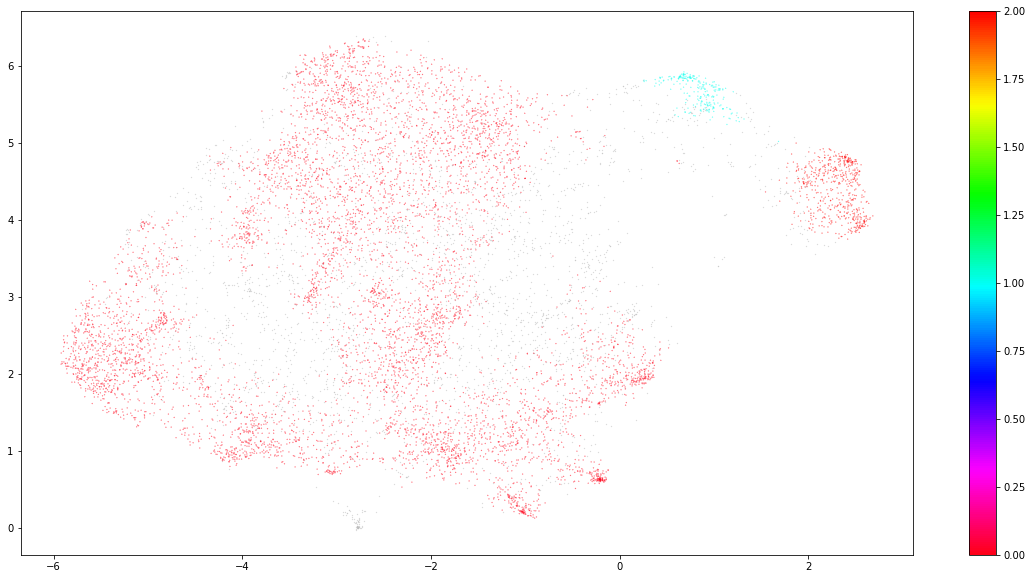

In [72]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [73]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [74]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [75]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
1,0,6731
0,-1,2483
3,2,550
2,1,236


In [76]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')


['coronavirus', 'covid', '19', 'covid19', 'cases', 'new', 'trump', 'people', 'vaccine', 'pandemic']

['good', 'great', 'oh', 'read', 'news', 'just', 'thread', 'god', 'let', 'prayers']

['don', 'fucking', 'fuck', 'just', 'sad', 'holy', 'shit', 'terrible', 'dumbass', 'hell']



## Italiano

In [77]:
file = open(italian_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
text_raw = pd.json_normalize(data)

print(text_raw.shape)
text_raw.head(10)

(10000, 4)


,id,publication_date,source,text
0,1324811856859533313,1.604695e+09,twitter,Il prof. #Galli è molto preoccupato da quanto ...
1,1288746494368124928,1.596096e+09,twitter,Il COVID-19 coincide con un momento cruciale n...
2,1326191597785059329,1.605024e+09,twitter,Muoviamoci #vaccinoCovid #coronavirus #COVID19...
3,1275134048722132993,1.592851e+09,twitter,@mosllerdd @Cartabellotta Si sarebbero potute ...
4,1243118079091118080,1.585217e+09,twitter,@morzo6 @CNN Purtroppo sì. State a casa. Disin...
5,1267645840455278594,1.591065e+09,twitter,"@orticArya * ""il coronavirus non c'è più, ma c..."
6,1233340720460726272,1.582886e+09,twitter,"Coronavirus, l’ultima trovata: mascherine grif..."
7,1279712208612667393,1.593942e+09,twitter,"""Penne in quarantena"". Tredici #racconti di al..."
8,1271709738301095936,1.592034e+09,twitter,"Cina, torna l’incubo Coronavirus: alcuni quart..."
9,1296853994686513152,1.598029e+09,twitter,Questo è il punto


In [78]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Il prof. #Galli è molto preoccupato da quanto sta accadendo a #Milano '

##@ Arquitectura 1

In [79]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(raw_texts, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

### UMAP para reducir la dimensionalidad de los embeddings
#### Esto permite una mejor clasificación para el clustering

In [80]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=30,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

### HDBSCAN para el clustering

In [81]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

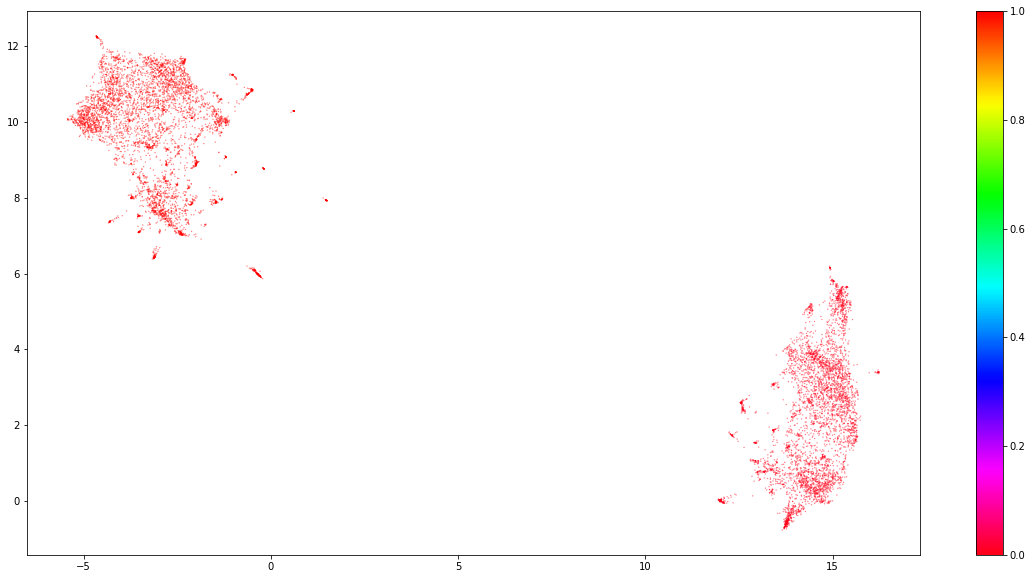

In [82]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [83]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [84]:
!pip install stop-words

You should consider upgrading via the '/Users/isabelasarmiento/pythonProject/venv/bin/python -m pip install --upgrade pip' command.


In [85]:
from stop_words import get_stop_words

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('italian')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [86]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
1,1,5316
0,0,4684


In [87]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')


['coronavirus', 'casi', 'nuovi', 'italia', 'positivi', 'contagi', 'morti', 'via', 'bollettino', 'oggi']

['covid19', 'covid', '19', 'italia', 'oggi', 'solo', 'vaccino', 'cosa', 'dopo', 'emergenza']



## Español

In [88]:
file = open(spanish_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
text_raw = pd.json_normalize(data)

print(text_raw.shape)
text_raw.head(10)

(10000, 4)


,id,publication_date,source,text
0,1304391319972790274,1.599826e+09,twitter,ORACIÓN DIARIAViernes 11 de Septiembre 2020#or...
1,1308823479077175297,1.600883e+09,twitter,Se pudrió todo. Acá la FIFA debe castigar a la...
2,1255929719893221377,1.588272e+09,twitter,Última Publicación en la Prensaldia - @ca...
3,1367024221319286784,1.614759e+09,twitter,Australia = 0 positivos por coronavirus.¿Vacun...
4,1278689023087849480,1.593698e+09,twitter,coronavirus esto ya es personal
5,1374234992969015297,1.616478e+09,twitter,"#LadyZopilota, zopiloteando en la noticia."
6,1296604758732570625,1.597970e+09,twitter,La noticia que esperaban los mercados. Gracias...
7,1344926278592438272,1.609490e+09,twitter,No caigamos en la trampa.En México ya iniciaro...
8,1311046706809786372,1.601413e+09,twitter,El coronavirus se ha confirmado ya en más de 2...
9,1257004539875667971,1.588528e+09,twitter,@JaimeChincha @RPPNoticias Mi padre acaba de m...


In [89]:
'''
Turn text to Numpy Array
'''
texts_column = text_raw.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'ORACIÓN DIARIAViernes 11 de Septiembre 2020#oraciondiaria #11DeSeptiembre #BuenosDias #BuenosDiasATodos… '

## Arquitectura 1

In [90]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(raw_texts, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

### UMAP para reducir la dimensionalidad de los embeddings
#### Esto permite una mejor clasificación para el clustering

In [91]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=30,
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

### HDBSCAN para el clustering

In [57]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=50,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

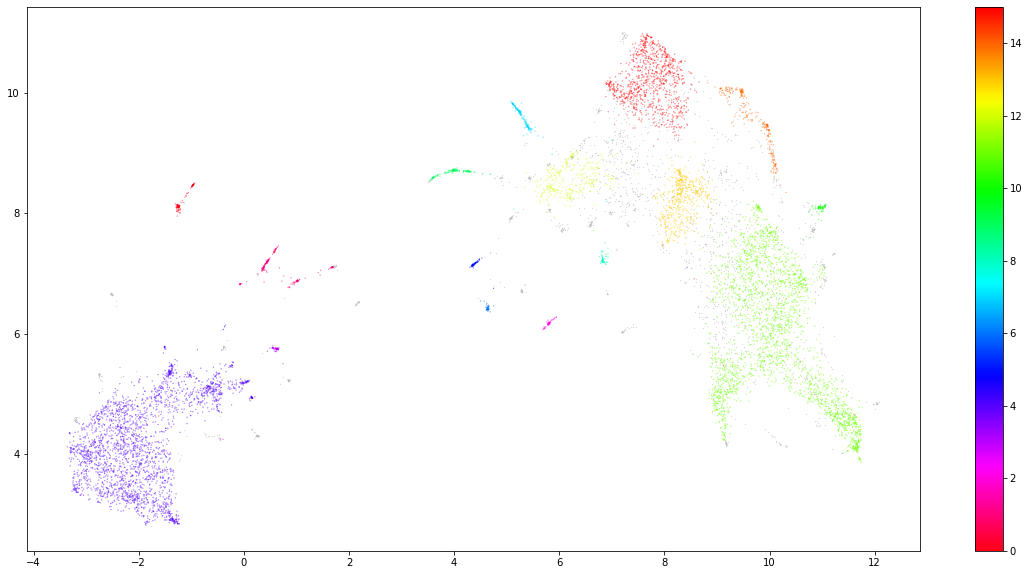

In [58]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [59]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [60]:
from stop_words import get_stop_words

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words=get_stop_words('spanish')).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [61]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
5,4,2590
12,11,2589
0,-1,1779
16,15,947
14,13,533
13,12,303
15,14,250
2,1,200
8,7,173
10,9,147


In [62]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')

['coronavirus', 'casos', 'nuevos', 'si', 'virus', 'pandemia', 'muertes', 'mundo', 'muertos', 'españa']

['si', 'gobierno', 'ser', 'gente', 'salud', 'gracias', 'así', 'ahora', 'hacer', 'hace']

['19', 'covid', 'vacuna', 'positivo', 'casos', 'vía', 'crisis', 'pandemia', 'vacunas', 'gobierno']

['covid19', 'si', 'vacuna', 'pandemia', 'vacunas', 'casos', 'personas', 'positivo', 'dos', 'contagios']

['casos', '000', 'covid', '19', 'nuevos', 'covid19', 'millones', '50', '500', 'positivos']

['hospital', 'covid', '19', 'hospitales', 'médico', 'médicos', 'pacientes', 'medidas', 'personal', 'hospitalizado']

['argentina', 'chile', 'coronavirus', 'casos', 'brasil', 'muertes', '24', 'horas', 'nuevos', 'últimas']

['méxico', 'mil', 'covid', '19', 'muertes', 'covid19', 'casos', 'confirmados', 'mexicanos', 'mexicano']

['2020', '2021', '19', 'covid', 'covid19', 'año', '2019', '03', 'julio', '11']

['china', 'coronavirus', 'wuhan', 'muertos', 'virus', 'origen', 'brote', 'covid19', 'vacuna', 'in']

['